# Estimating Indirect Nutrient Load from PT

# Imports

In [1]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

# Helper Function 

In [2]:
# Define the function to sort the files based on the time
def sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the `.nc` extension
        number = int(filename.split('_')[-1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Inputs

In [ ]:

# -----------------------------
# Define Core Directories
# -----------------------------
GIS_LAYERS = '/home/abolmaal/Data/GIS_layer'  # For general GIS layers
CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/CoastalWatersheds/Erase_Riperian'  # Coastal wetlands (50m buffer)
# CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline/'  # Alternative path (optional)

# -----------------------------
# Coastal Wetland Shapefiles (Buffered 50m)
# -----------------------------
CW_avg_path   = os.path.join(CW_path, 'Wetland_connected_avg_erasebuff_50.shp')
CW_low_path   = os.path.join(CW_path, 'Wetland_connected_low_erasebuff_50.shp')
CW_high_path  = os.path.join(CW_path, 'Wetland_connected_high_erasebuff_50.shp')
CW_surge_path = os.path.join(CW_path, 'Wetland_connected_surge_erasebuff_50.shp')

# Load shapefiles as GeoDataFrames
CW_avg   = gpd.read_file(CW_avg_path)
CW_low   = gpd.read_file(CW_low_path)
CW_high  = gpd.read_file(CW_high_path)
CW_surge = gpd.read_file(CW_surge_path)

# -----------------------------
# FVCOM Particle Tracking Output Files
# -----------------------------
data_dir = '/home/abolmaal/modelling/FVCOM/Huron/output'
files = glob.glob(os.path.join(data_dir, "particleload_updated_FVCOM_Huron_2323_*.nc"))
files.sort(key=sort_key)

# FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'

# -----------------------------
# Direct Nutrient Load (Stream Watersheds)
# -----------------------------
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/DirectTNTP_StreamWatresheds.csv'
DirectStreamWatershed_NutrientLoad = pd.read_csv(Direct_Nutrient_load)

# Optional: Rename columns to standard NetCDF field names
required_columns = {
    'Group_id': 'group_id',
    'StreamDirectTN_kgday': 'StreamDirectTN_kgday',
    'StreamDirectTP_kgday': 'StreamDirectTP_kgday',
    'StreamDirectTN_grm2yr': 'StreamDirectTN_grm2yr',
    'StreamDirectTP_grm2yr': 'StreamDirectTP_grm2yr'
}
DirectStreamWatershed_NutrientLoad.rename(columns=required_columns, inplace=True)


In [4]:
#set the crs of cw_avg to 3174
CW_avg.to_crs('EPSG:3174', inplace=True)
CW_low.to_crs('EPSG:3174', inplace=True)
CW_high.to_crs('EPSG:3174', inplace=True)
CW_surge.to_crs('EPSG:3174', inplace=True)

In [5]:
# in CW_low rename the column Cw_Area to CW_Area and column Cw_Id to CW_Id
CW_low.rename(columns={'Cw_Area': 'CW_Area', 'Cw_Id': 'CW_Id'}, inplace=True)

In [6]:
# read the CW_avg shapefile and print the lenght of the shapefile 
print(f'Length of CW_avg: {len(CW_avg)}')

Length of CW_avg: 4249


# Outputs

In [ ]:
# Define the year suffix
year = 2023
year_suffix = str(year)[-2:]  # '23' if year is 2023

# Output paths
output_path = '/home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load'
output_figures = '/home/abolmaal/modelling/FVCOM/Huron/figures/InDirectNPLoad'

# FVCOM model output shapefile
originalFVCOM = f'LakeHuronparticletracking_{year}_original.shp'

# Intersected outputs with coastal wetlands
Intersection_PTCW_Avg = f'Intersections_Avg_PTCW_{year_suffix}.csv'
Intersection_PTCW_high = f'Intersections_high_PTCW_{year_suffix}.csv'
Intersection_PTCW_low = f'Intersections_low_PTCW_{year_suffix}.csv'
Intersection_PTCW_surge = f'Intersections_surge_PTCW_{year_suffix}.csv'
# Intersection summary
Intersection_summary_avg = f'Intersection_summary_PTCW_avg_{year_suffix}.csv'
Intersection_summary_high = f'Intersection_summary_PTCW_high_{year_suffix}.csv'
Intersection_summary_low = f'Intersection_summary_PTCW_low_{year_suffix}.csv'
Intersection_summary_surge = f'Intersection_summary_PTCW_surge_{year_suffix}.csv'

# Monthly intersected outputs
Intersection_PTCW_Avg_monthly = f'Intersections_Avg_PTCW_monthly_{year_suffix}.csv'
Intersection_PTCW_high_monthly = f'Intersections_high_PTCW_monthly_{year_suffix}.csv'
Intersection_PTCW_low_monthly = f'Intersections_low_PTCW_monthly_{year_suffix}.csv'
Intersection_PTCW_surge_monthly = f'Intersections_surge_PTCW_monthly_{year_suffix}.csv'

# Group ID and Non-intersections
GroupIdcount = f'group_id_counts_{year_suffix}.csv'
Non_Intersection_avg = f'Non_Intersection_avg_{year_suffix}.csv'
Non_Intersection_high = f'Non_Intersection_high_{year_suffix}.csv'
Non_Intersection_low = f'Non_Intersection_low_{year_suffix}.csv'
Non_Intersection_surge = f'Non_Intersection_surge_{year_suffix}.csv'

# outnames for the figures
fig_histogram = f'Histogram_PTCW_{year_suffix}.png'



# Parameters

In [ ]:

release_times = ["2301", "2302", "2303", "2304", "2305", "2306", "2307", "2308", "2309", "2310", "2311", "2312"]

# Figure parameters
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface
reversed_plasma_cmap = plasma_cmap.reversed()  # Reversed colormap  
# Set up plotting parameters
font_size = 15
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)

# Extent of the plot
extents = np.array([275, 277.69, 43, 46.3], dtype=float)

extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
# Fields to calculate / Direct delivery to Watersheds
StreamDirectTN = 'StreamDirectTN_kgday'
StreamDirectTP = 'StreamDirectTP_kgday'


# Creating a geodaframe for each individual run then find the first intersection with the coastal wetlands and save the results


In [8]:
def save_first_intersection_per_file_with_stats(nc_file, CW, output_dir, release_time_str, cw_level):
    """
    Processes a single NetCDF file to:
    - Extract particle data
    - Fix longitudes >180
    - Convert to GeoDataFrame
    - Compute first intersection with CW shapefile
    - Save results and print intersection percentage

    Returns:
    - percentage: float, percent of intersected particles
    - total_particles: int
    - intersected_particles: int
    """
    print(f"🔍 Processing {os.path.basename(nc_file)} with release time {release_time_str} for {cw_level}...")

    with xr.open_dataset(nc_file) as ds:
        selected_vars = ds[['time', 'group_id', 'particle_id', 'longitude', 'latitude',
                            'StreamTN_kgdayparticle', 'StreamTP_kgdayparticle']]

        # Fix longitudes > 180°
        selected_vars['longitude'].values = np.where(
            selected_vars['longitude'].values > 180,
            selected_vars['longitude'].values - 360,
            selected_vars['longitude'].values
        )

        df = selected_vars.to_dataframe().reset_index()

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
    gdf.set_crs('EPSG:4326', inplace=True)
    gdf = gdf.to_crs('EPSG:3174')  # Match CW CRS

    total_particles = gdf['particle_id'].nunique()

    # Intersections
    intersecting = gdf[gdf.geometry.intersects(CW.geometry.union_all())]

    if not intersecting.empty:
        intersecting = intersecting.sort_values(by=['particle_id', 'time'])
        first_intersections = intersecting.drop_duplicates(subset='particle_id', keep='first')

        # Spatial join with CW info
        joined = gpd.sjoin(
            first_intersections,
            CW[['geometry', 'CW_Area', 'CW_Id']],
            how='left',
            predicate='intersects'
        )

        output_csv = os.path.join(output_dir, f"intersection_{release_time_str}_{cw_level}.csv")
        joined.to_csv(output_csv, index=False)

        intersected_particles = joined['particle_id'].nunique()
        percentage = (intersected_particles / total_particles) * 100 if total_particles else 0

        print(f"✅ {intersected_particles}/{total_particles} particles intersected ({percentage:.2f}%) — saved to {output_csv}")
    else:
        intersected_particles = 0
        percentage = 0
        print(f"⚠️ No intersections found for {release_time_str} with {cw_level}.")

    gc.collect()
    return percentage, total_particles, intersected_particles

In [9]:
# Gather and sort NetCDF files
updated_files = glob.glob(os.path.join(data_dir, "particleload_updated_FVCOM_Huron_2323_*.nc"))
updated_files.sort(key=sort_key)

# Alias for clarity
nc_files = updated_files
print(nc_files)

['/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_JanFeb_1.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_FebMar_2.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_MarApr_3.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_AprMay_4.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_MayJun_5.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_JunJul_6.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_JulAug_7.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_AugSep_8.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_SepOct_9.nc', '/home/abolmaal/modelling/FVCOM/Huron/output/particleload_updated_FVCOM_Huron_2323_OctNov_10.nc', '/home/abolmaal/modelling/FV

# Intersection with avg Inundation

In [ ]:
# running the function to find the intersection of the particles with the coastal wetlands with the average inundation level
# Step 2: Loop through each file and release time
summary_data = []

for file, rtime in zip(updated_files, release_times):
    pct, total, intersected = save_first_intersection_per_file_with_stats(file, CW_avg, output_path, rtime,cw_level='avg')
    summary_data.append({
        'release_time': rtime,
        'total_particles': total,
        'intersected_particles': intersected,
        'percentage': round(pct, 2)
        
    })

# Step 3: Save summary stats to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(output_path, Intersection_summary_avg)
summary_df.to_csv(summary_csv, index=False)
print(f"📄 Saved summary to {summary_csv}")

🔍 Processing particleload_updated_FVCOM_Huron_2323_JanFeb_1.nc with release time 2301 for avg...
✅ 1563/8550 particles intersected (18.28%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2301_avg.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_FebMar_2.nc with release time 2302 for avg...
✅ 1282/8550 particles intersected (14.99%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2302_avg.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_MarApr_3.nc with release time 2303 for avg...
✅ 3332/8550 particles intersected (38.97%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2303_avg.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_AprMay_4.nc with release time 2304 for avg...
✅ 1574/8550 particles intersected (18.41%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2304_avg.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_MayJun_5.nc with release time

# Intersection with high Inundation

In [ ]:
# Step 2: Loop through each file and release time
summary_data = []

for file, rtime in zip(updated_files, release_times):
    pct, total, intersected = save_first_intersection_per_file_with_stats(file, CW_high, output_path, rtime,cw_level='high')
    summary_data.append({
        'release_time': rtime,
        'total_particles': total,
        'intersected_particles': intersected,
        'percentage': round(pct, 2)
        
    })

# Step 3: Save summary stats to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(output_path, Intersection_summary_high)
summary_df.to_csv(summary_csv, index=False)
print(f"📄 Saved summary to {summary_csv}")


🔍 Processing particleload_updated_FVCOM_Huron_2323_JanFeb_1.nc with release time 2301 for high...
✅ 1602/8550 particles intersected (18.74%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2301_high.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_FebMar_2.nc with release time 2302 for high...
✅ 1338/8550 particles intersected (15.65%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2302_high.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_MarApr_3.nc with release time 2303 for high...
✅ 3565/8550 particles intersected (41.70%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2303_high.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_AprMay_4.nc with release time 2304 for high...
✅ 1695/8550 particles intersected (19.82%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2304_high.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_MayJun_5.nc with rele

# Intersection with low Inundation

In [ ]:
# Step 2: Loop through each file and release time
summary_data = []

for file, rtime in zip(updated_files, release_times):
    pct, total, intersected = save_first_intersection_per_file_with_stats(file, CW_low, output_path, rtime,cw_level='low')
    summary_data.append({
        'release_time': rtime,
        'total_particles': total,
        'intersected_particles': intersected,
        'percentage': round(pct, 2)
        
    })

# Step 3: Save summary stats to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(output_path, Intersection_summary_low)
summary_df.to_csv(summary_csv, index=False)
print(f"📄 Saved summary to {summary_csv}")

🔍 Processing particleload_updated_FVCOM_Huron_2323_JanFeb_1.nc with release time 2301 for low...
✅ 1450/8550 particles intersected (16.96%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2301_low.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_FebMar_2.nc with release time 2302 for low...
✅ 1181/8550 particles intersected (13.81%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2302_low.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_MarApr_3.nc with release time 2303 for low...
✅ 2975/8550 particles intersected (34.80%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2303_low.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_AprMay_4.nc with release time 2304 for low...
✅ 1468/8550 particles intersected (17.17%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2304_low.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_MayJun_5.nc with release time

# Intersection with surge Inundation

In [ ]:
# Step 2: Loop through each file and release time
summary_data = []

for file, rtime in zip(updated_files, release_times):
    pct, total, intersected = save_first_intersection_per_file_with_stats(file, CW_surge, output_path, rtime,cw_level='surge')
    summary_data.append({
        'release_time': rtime,
        'total_particles': total,
        'intersected_particles': intersected,
        'percentage': round(pct, 2)
        
    })

# Step 3: Save summary stats to CSV
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(output_path, Intersection_summary_surge)
summary_df.to_csv(summary_csv, index=False)
print(f"📄 Saved summary to {summary_csv}")

🔍 Processing particleload_updated_FVCOM_Huron_2323_JanFeb_1.nc with release time 2301 for surge...
✅ 1623/8550 particles intersected (18.98%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2301_surge.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_FebMar_2.nc with release time 2302 for surge...
✅ 1350/8550 particles intersected (15.79%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2302_surge.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_MarApr_3.nc with release time 2303 for surge...
✅ 3806/8550 particles intersected (44.51%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2303_surge.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_AprMay_4.nc with release time 2304 for surge...
✅ 1754/8550 particles intersected (20.51%) — saved to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/intersection_2304_surge.csv
🔍 Processing particleload_updated_FVCOM_Huron_2323_MayJun_5.nc w

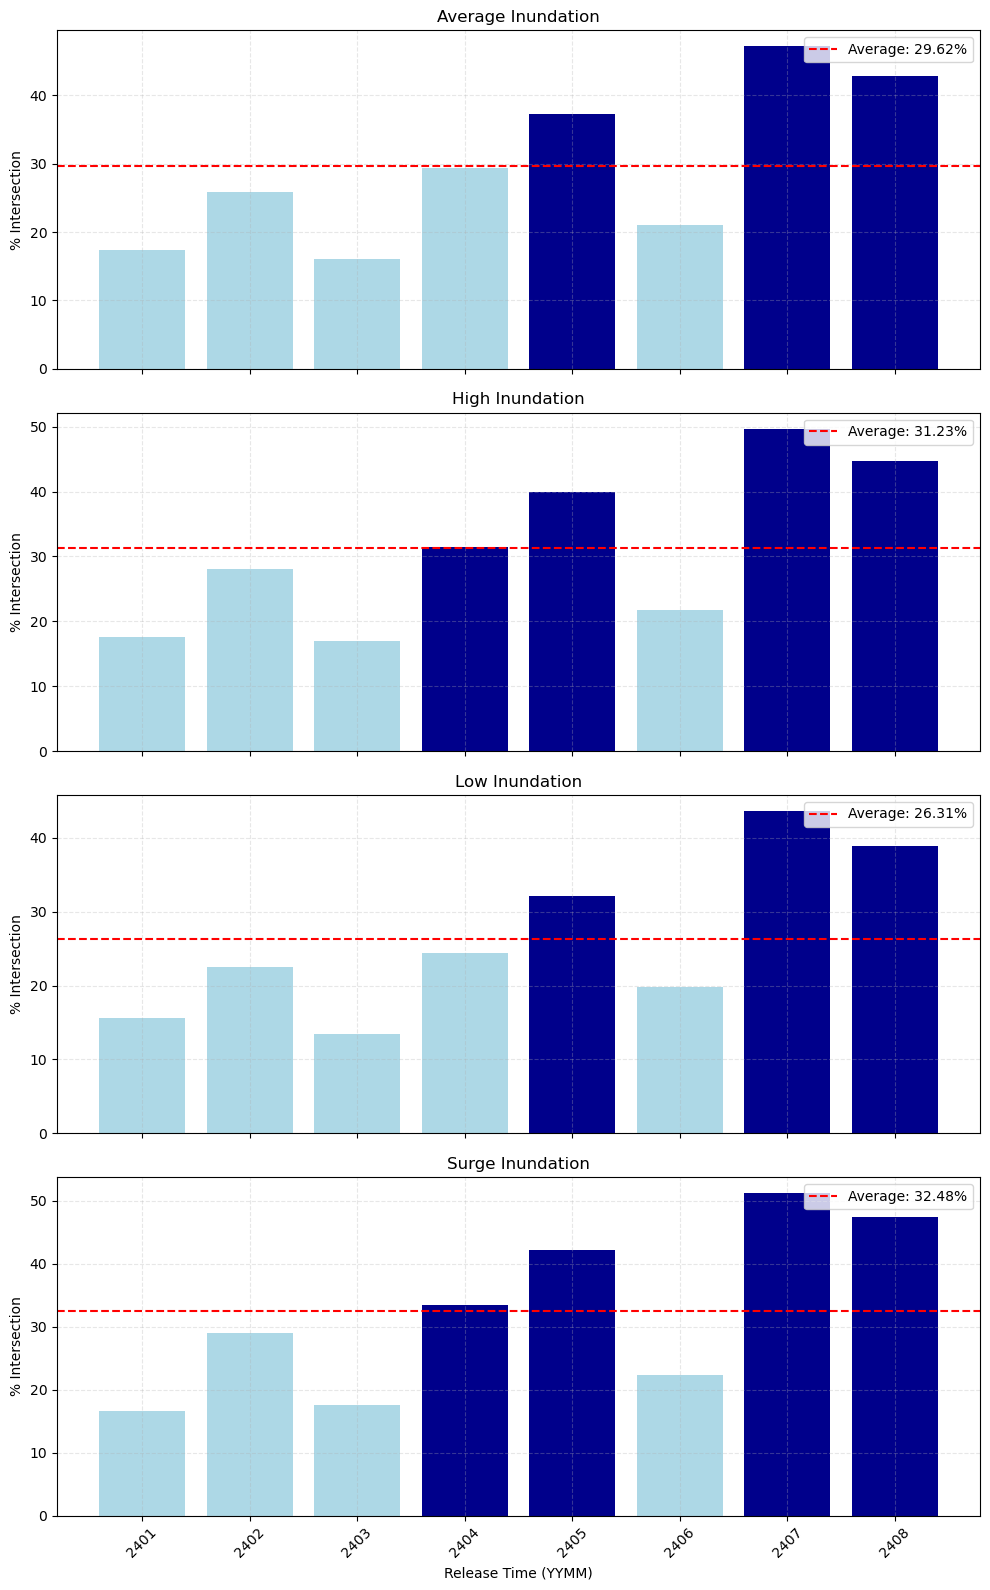

In [ ]:
# read the summary CSV files for avg, high, low, and surge inundation levels
summary_avg = pd.read_csv(os.path.join(output_path, Intersection_summary_avg))
summary_high = pd.read_csv(os.path.join(output_path, Intersection_summary_high))
summary_low = pd.read_csv(os.path.join(output_path, Intersection_summary_low))
summary_surge = pd.read_csv(os.path.join(output_path, Intersection_summary_surge))

# Store all summaries in a list with labels
summaries = [
    ('Average Inundation', summary_avg),
    ('High Inundation', summary_high),
    ('Low Inundation', summary_low),
    ('Surge Inundation', summary_surge)
]

# Create 4,1 subplot layout
fig, axes = plt.subplots(4, 1, figsize=(10, 16), sharex=True)

for ax, (title, summary_df) in zip(axes, summaries):
    # Step 1: Conditional colors
    colors = ['darkblue' if p >= 30 else 'lightblue' for p in summary_df['percentage']]
    
    # Step 2: Bar plot
    ax.bar(summary_df['release_time'], summary_df['percentage'], color=colors)
    
    # Step 3: Average line
    avg = summary_df['percentage'].mean()
    ax.axhline(y=avg, color='red', linestyle='--', label=f'Average: {avg:.2f}%')
    
    # Step 4: Titles and styling
    ax.set_title(title)
    ax.set_ylabel('% Intersection')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.3)

# Shared x-label and formatting
axes[-1].set_xlabel('Release Time (YYMM)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_figures, fig_histogram), dpi=300)
plt.show()

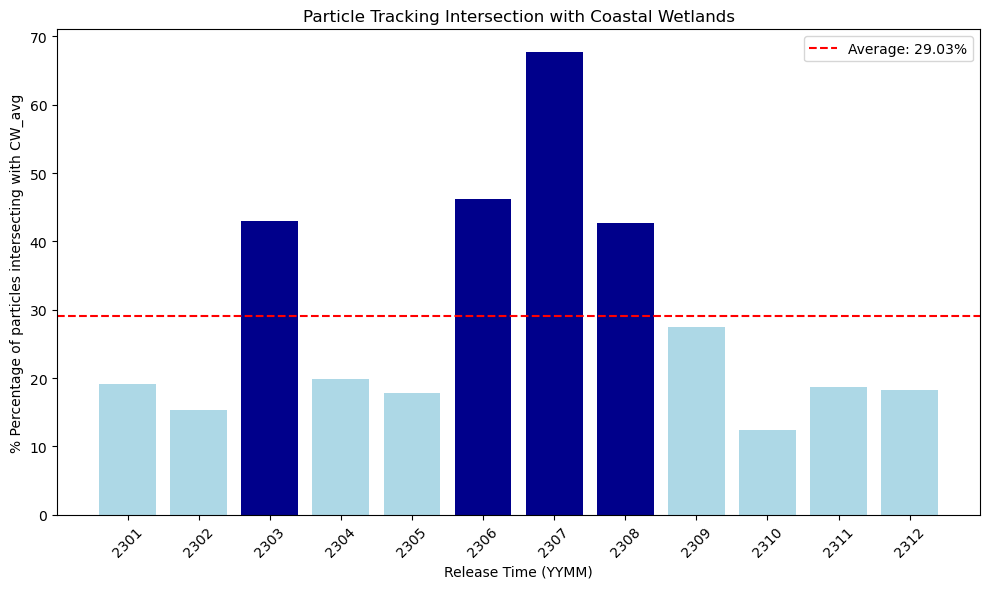

In [19]:
# Step 1: Create conditional color list
colors = ['darkblue' if p >= 30 else 'lightblue' for p in summary_df['percentage']]

# Step 2: Plot with conditional colors
plt.figure(figsize=(10, 6))
plt.bar(summary_df['release_time'], summary_df['percentage'], color=colors)

# Step 3: Add average line
average_percentage = summary_df['percentage'].mean()
plt.axhline(y=average_percentage, color='red', linestyle='--', label=f'Average: {average_percentage:.2f}%')

# Step 4: Final plot tweaks
plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Release Time (YYMM)')
plt.ylabel('% Percentage of particles intersecting with CW_avg')
plt.title('Particle Tracking Intersection with Coastal Wetlands')
plt.tight_layout()
plt.show()

# Estimating N P Loads

## Bring in all the intersections in one file 

In [ ]:
# read all the intersection files and concatenate them into one dataframe
intersection_files = glob.glob(os.path.join(output_path, "intersection_23??_avg.csv"))
intersection_dfs = []
for intersection_file in intersection_files:
    df = pd.read_csv(intersection_file)
    df['release_time'] = os.path.basename(intersection_file).split('_')[1]  # Extract release time from filename
    intersection_dfs.append(df)
# Concatenate all DataFrames
intersection_df = pd.concat(intersection_dfs, ignore_index=True)

In [ ]:
intersection_df
# save the intersection dataframe to a csv file
intersection_csv = os.path.join(output_path, "intersection_all_23_avg.csv")
intersection_df.to_csv(intersection_csv, index=False)

In [22]:
intersection_df
# read the intersection dataframe from the csv file


,time,particles,group_id,particle_id,longitude,latitude,StreamTN_kgdayparticle,StreamTP_kgdayparticle,geometry,index_right,CW_Area,CW_Id,release_time
0,2023-03-10 06:00:00,40,0,402302,-83.314730,45.126200,0.179744,0.012996,POINT (1089623.6164265533 951338.7503559467),342,301047,347,2302
1,2023-02-03 06:00:00,160,4,4102302,-83.478455,45.345226,0.363341,0.017693,POINT (1076469.8352991191 975552.2248475521),203,1873344,208,2302
2,2023-02-01 00:00:00,225,9,9002302,-83.825590,45.428100,0.887714,0.034116,POINT (1049241.6413718385 984507.3720524387),145,18493,149,2302
3,2023-02-03 06:00:00,248,9,9232302,-83.467530,45.330772,0.887714,0.034116,POINT (1077344.2685766714 973953.5522919794),212,3208587,217,2302
4,2023-02-01 00:00:00,525,14,14002302,-83.367190,45.170500,1.761071,0.067251,POINT (1085437.264918439 956213.083986351),296,61723994,301,2302
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27916,2023-06-16 18:00:00,8544,162,162692306,-83.881165,43.659798,383.363511,13.290446,POINT (1046307.4993240066 787670.9704539112),3726,70601,3810,2306
27917,2023-06-30 06:00:00,8545,162,162702306,-83.945800,43.763783,383.363511,13.290446,POINT (1041026.793294103 799203.3427740362),3055,4366897,3129,2306
27918,2023-07-07 00:00:00,8546,162,162712306,-83.913580,43.884026,383.363511,13.290446,POINT (1043527.6379934757 812597.4212222599),2115,860637,2172,2306
27919,2023-06-30 00:00:00,8547,162,162722306,-83.946420,43.760643,383.363511,13.290446,POINT (1040979.3074495036 798853.7712130235),3097,1188375,3171,2306


In [23]:
# count the number of unique day in the intersection_df
unique_days = intersection_df['time'].nunique()
print(f"Number of unique release days in intersection_df: {unique_days}")

Number of unique release days in intersection_df: 1145


In [24]:
# Convert the 'time' column to datetime
intersection_df['time'] = pd.to_datetime(intersection_df['time'], format='%Y-%m-%d %H:%M:%S')

# Extract the date (drop the time part)
intersection_df['date_only'] = intersection_df['time'].dt.date

# Count number of unique days
unique_days = intersection_df['date_only'].nunique()
print(f"Number of unique release days in intersection_df: {unique_days}")

Number of unique release days in intersection_df: 344


In [25]:
# Convert 'time' column to datetime if not already
intersection_df['time'] = pd.to_datetime(intersection_df['time'], format='%Y-%m-%d %H:%M:%S')

# Extract month as a period (e.g., 2023-03)
intersection_df['month'] = intersection_df['time'].dt.to_period('M')

# Count number of unique months
unique_months = intersection_df['month'].nunique()
print(f"Number of unique months in intersection_df: {unique_months}")


Number of unique months in intersection_df: 13


## Estimate the Total Indirect load for each Coastal wetland

The following code estimate the total N & P for each coastal wetland
then converts the values from kgday to kg/year/m2

In [26]:
def calculate_indirect_cw_flux(intersection_df):
    """
    Calculates indirect nutrient flux to coastal wetlands (CW) in g/m²/yr using:
    (total_mass * 1000 / CW_Area) * unique_days

    Parameters:
    - intersection_df: DataFrame with nutrient per particle, time, and CW_Area
      Required columns:
        ['CW_Id', 'StreamTN_kgdayparticle', 'StreamTP_kgdayparticle', 'time', 'CW_Area']

    Returns:
    - intersection_df with added columns:
        ['totalTN_mass_per_CW_Id', 'totalTP_mass_per_CW_Id',
         'IndirectCW_TN_grm2yr', 'IndirectCW_TP_grm2yr']
    """

    # Convert 'time' to datetime
    intersection_df['time'] = pd.to_datetime(intersection_df['time'])

    # Count number of unique days (by date only)
    intersection_df['date_only'] = intersection_df['time'].dt.date
    unique_days = intersection_df['date_only'].nunique()

    # Total TN and TP per CW_Id
    intersection_df['totalTN_per_CW_Id'] = intersection_df.groupby('CW_Id')['StreamTN_kgdayparticle'].transform('sum')
    intersection_df['totalTP_per_CW_Id'] = intersection_df.groupby('CW_Id')['StreamTP_kgdayparticle'].transform('sum')

    # Compute Indirect Load using your formula
    intersection_df['TotalIndirectCW_TN_grm2yr'] = (
        (intersection_df['totalTN_per_CW_Id'] * 1000) / (intersection_df['CW_Area'] )
    )
    intersection_df['TotalIndirectCW_TP_grm2yr'] = (
        (intersection_df['totalTP_per_CW_Id'] *  1000) / (intersection_df['CW_Area'])
    )

    return intersection_df


In [27]:
updated_df_CW_avg = calculate_indirect_cw_flux(intersection_df)
updated_df_CW_avg

,time,particles,group_id,particle_id,longitude,latitude,StreamTN_kgdayparticle,StreamTP_kgdayparticle,geometry,index_right,CW_Area,CW_Id,release_time,date_only,month,totalTN_per_CW_Id,totalTP_per_CW_Id,TotalIndirectCW_TN_grm2yr,TotalIndirectCW_TP_grm2yr
0,2023-03-10 06:00:00,40,0,402302,-83.314730,45.126200,0.179744,0.012996,POINT (1089623.6164265533 951338.7503559467),342,301047,347,2302,2023-03-10,2023-03,0.179744,0.012996,0.000597,0.000043
1,2023-02-03 06:00:00,160,4,4102302,-83.478455,45.345226,0.363341,0.017693,POINT (1076469.8352991191 975552.2248475521),203,1873344,208,2302,2023-02-03,2023-02,11.451045,0.650842,0.006113,0.000347
2,2023-02-01 00:00:00,225,9,9002302,-83.825590,45.428100,0.887714,0.034116,POINT (1049241.6413718385 984507.3720524387),145,18493,149,2302,2023-02-01,2023-02,10.652564,0.409396,0.576032,0.022138
3,2023-02-03 06:00:00,248,9,9232302,-83.467530,45.330772,0.887714,0.034116,POINT (1077344.2685766714 973953.5522919794),212,3208587,217,2302,2023-02-03,2023-02,169.686179,5.847801,0.052885,0.001823
4,2023-02-01 00:00:00,525,14,14002302,-83.367190,45.170500,1.761071,0.067251,POINT (1085437.264918439 956213.083986351),296,61723994,301,2302,2023-02-01,2023-02,287.056320,11.348740,0.004651,0.000184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27916,2023-06-16 18:00:00,8544,162,162692306,-83.881165,43.659798,383.363511,13.290446,POINT (1046307.4993240066 787670.9704539112),3726,70601,3810,2306,2023-06-16,2023-06,583.517745,17.664308,8.265007,0.250199
27917,2023-06-30 06:00:00,8545,162,162702306,-83.945800,43.763783,383.363511,13.290446,POINT (1041026.793294103 799203.3427740362),3055,4366897,3129,2306,2023-06-30,2023-06,2798.075183,95.806066,0.640747,0.021939
27918,2023-07-07 00:00:00,8546,162,162712306,-83.913580,43.884026,383.363511,13.290446,POINT (1043527.6379934757 812597.4212222599),2115,860637,2172,2306,2023-07-07,2023-07,1019.479089,32.954647,1.184563,0.038291
27919,2023-06-30 00:00:00,8547,162,162722306,-83.946420,43.760643,383.363511,13.290446,POINT (1040979.3074495036 798853.7712130235),3097,1188375,3171,2306,2023-06-30,2023-06,4236.984991,143.283719,3.565360,0.120571


In [28]:
# print min and max of the IndirectCW_TN_grm2yr and IndirectCW_TP_grm2yr
print(f"Minimum IndirectCW_TN_grm2yr: {updated_df_CW_avg['TotalIndirectCW_TN_grm2yr'].min()}")
print(f"Maximum IndirectCW_TN_grm2yr: {updated_df_CW_avg['TotalIndirectCW_TN_grm2yr'].max()}")
# print the median of the IndirectCW_TN_grm2yr
print(f"Median IndirectCW_TN_grm2yr: {updated_df_CW_avg['TotalIndirectCW_TN_grm2yr'].median()}")


print(f"Minimum IndirectCW_TP_grm2yr: {updated_df_CW_avg['TotalIndirectCW_TP_grm2yr'].min()}")
print(f"Maximum IndirectCW_TP_grm2yr: {updated_df_CW_avg['TotalIndirectCW_TP_grm2yr'].max()}")
# print the median of the IndirectCW_TP_grm2yr
print(f"Median IndirectCW_TP_grm2yr: {updated_df_CW_avg['TotalIndirectCW_TP_grm2yr'].median()}")

Minimum IndirectCW_TN_grm2yr: 7.919683697838178e-06
Maximum IndirectCW_TN_grm2yr: 161.87734661308656
Median IndirectCW_TN_grm2yr: 0.3979038519606141
Minimum IndirectCW_TP_grm2yr: 1.4995161126286308e-06
Maximum IndirectCW_TP_grm2yr: 5.514071569162749
Median IndirectCW_TP_grm2yr: 0.010595293221233499


In [29]:
# drop the columns where correcpond to the same values of CW_Id
updated_df_CW_avg = updated_df_CW_avg.drop_duplicates(subset='CW_Id', keep='first')

In [ ]:
# selecte the following  columns 'time','group_id','particle_id','longitude','latitude','CW_Id','CW_Area','totalTP_mass_per_CW_Id','IndirectCW_TN_grm2yr','IndirectCW_TP_grm2yr'
selected_columns = ['time', 'group_id', 'particle_id', 'longitude', 'latitude', 'CW_Id', 'CW_Area','TotalIndirectCW_TN_grm2yr', 'TotalIndirectCW_TP_grm2yr']
updated_df_CW_avg = updated_df_CW_avg[selected_columns]
# Save the intersection DataFrame to a CSV file
intersection_output_csv = os.path.join(output_path, "InDirectedNP_CW_avg_23.csv")
# Save the DataFrame to a CSV file
updated_df_CW_avg.to_csv(intersection_output_csv, index=False)
print(f"📄 Saved intersection data to {intersection_output_csv}")

📄 Saved intersection data to /home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load/InDirectedNP_CW_avg_23.csv


# Main Functions


## Create a geodatafram from the particle tracking outputs

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from dask.delayed import delayed
import xarray as xr
from shapely.geometry import Point
import dask  # Import Dask to access dask.compute
from dask import compute  # Import the specific compute function
import gc  # To manually collect garbage and free up memory
from dask.distributed import Client


# Limit the number of workers and threads
client = Client(n_workers=2, threads_per_worker=1,memory_limit='8GB')  # Adjust as needed

print(client)
# Function to remove overlap in time
# def remove_overlap(datasets):
#     # Remove the first time step of each dataset except for the first one
#     datasets[1:] = [ds.sel(time=slice(ds['time'][1], None)) for ds in datasets[1:]]
#     return datasets

# Function to process a single file and convert to GeoDataFrame
@delayed
def process_file(file):
    # Open the dataset lazily with xarray (no data loaded yet)
    with xr.open_dataset(file) as ds:
        selected_vars = ds[['time', 'group_id', 'particle_id', 'longitude', 'latitude']]

        # Perform operations like longitude correction
        selected_vars['longitude'].values = np.where(selected_vars['longitude'].values > 180, 
                                                     selected_vars['longitude'].values - 360, 
                                                     selected_vars['longitude'].values)

        # Convert xarray to pandas dataframe
        PT_df = selected_vars.to_dataframe().reset_index()

        # Create GeoDataFrame from the DataFrame
        PT_gdf = gpd.GeoDataFrame(PT_df, geometry=gpd.GeoSeries.from_xy(PT_df['longitude'], PT_df['latitude']))

        # Set the CRS and reproject if necessary
        PT_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
        PT_gdf = PT_gdf.to_crs('EPSG:3174')

        # Release memory after processing the dataset
        del ds, selected_vars, PT_df  # Delete variables no longer needed
        gc.collect()  # Force garbage collection to release memory

        return PT_gdf

# Use dask.delayed to process each file (process files in smaller batches to avoid memory overload)
batch_size = 2  # Process in smaller batches of 2 files at a time
batches = [files[i:i + batch_size] for i in range(0, len(files), batch_size)]

all_gdfs = []

# Process each batch separately
for batch in batches:
    all_delayed = [process_file(file) for file in batch]
    batch_gdfs = compute(*all_delayed)  # Use dask.compute here
    all_gdfs.extend(batch_gdfs)  # Append the GeoDataFrames from this batch

    # Manually trigger garbage collection after each batch to release memory
    gc.collect()

# Now combine the GeoDataFrames from all batches into one
final_gdf = pd.concat(all_gdfs, ignore_index=True)
# Ensure time column is datetime
final_gdf['time'] = pd.to_datetime(final_gdf['time'], errors='coerce')

# Extract just the date (e.g., 2023-01-01)
final_gdf['day'] = final_gdf['time'].dt.date

# Set final CRS if necessary
#final_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
#final_gdf = final_gdf.to_crs('EPSG:3174')

# Final GeoDataFrame with all datasets
print(final_gdf)

In [ ]:
# save the final GeoDataFrame to a csv file
#final_gdf.to_csv(os.path.join(output_path, "PT_geodataframe"), index=False)

In [ ]:
PT_gdf = final_gdf

## countign the number of group_id per uniqe month

In [ ]:
import pandas as pd
import dask
from dask.delayed import delayed
import gc

# Convert the 'time' column to datetime if it's not already
def convert_to_datetime(gdf):
    gdf['time'] = pd.to_datetime(gdf['time'], errors='coerce')
    return gdf

# Create the 'month' column by extracting the year and month from the 'time' column
def add_month_column(gdf):
    gdf['month'] = gdf['time'].dt.to_period('M')
    return gdf

# Process the GeoDataFrame directly (no need for Dask read)
@delayed
def process_geo_data(gdf, month='2023-01'):
    # Convert 'time' to datetime and add the 'month' column
    gdf = convert_to_datetime(gdf)
    gdf = add_month_column(gdf)

    # Filter the data for the specific month (e.g., '2023-01')
    filtered_gdf = gdf[gdf['month'] == month]

    # Calculate the count of 'group_id' in the filtered data
    group_id_counts = filtered_gdf['group_id'].value_counts()

    # Optionally clear memory after processing the batch
    del gdf, filtered_gdf
    gc.collect()

    return group_id_counts

In [ ]:
# Use the in-memory GeoDataFrame (PT_gdf)
group_id_counts = process_geo_data(PT_gdf)  # PT_gdf is your in-memory GeoDataFrame

# If you want to compute the result, use .compute() to run it
group_id_counts_computed = group_id_counts.compute()

# Print the results
print(group_id_counts_computed)

# Set projections

In [ ]:
#set the crs of cw_avg to 3174
CW_avg.to_crs('EPSG:3174', inplace=True)
CW_low.to_crs('EPSG:3174', inplace=True)
CW_high.to_crs('EPSG:3174', inplace=True)
CW_surge.to_crs('EPSG:3174', inplace=True)

In [ ]:
PT_gdf.to_crs('EPSG:3174', inplace=True)

# Calculated monthly Intersection Seperately for each month 

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import gc

def calculate_monthly_first_intersections(gdf, CW_avg, output_path, output_csv="Intersection_PTCW_Avg.csv", summary_csv="Intersection_PTCW_Avg_monthly.csv"):
    """
    Loop through each month in the dataset, find only the first intersection per particle, 
    and save the results to a single CSV file. Also calculates the percentage of 
    intersecting particles per month.

    Parameters:
    - gdf: GeoDataFrame with 'time', 'group_id', 'group_number', 'geometry'
    - CW_avg: GeoDataFrame representing the wetland shapefile
    - output_path: Directory where the CSV files should be saved
    - output_csv: Optional output CSV filename (default is "Intersection_PTCW_Avg.csv")
    - summary_csv: Optional summary CSV filename (default is "Intersection_PTCW_Avg_monthly.csv")

    Returns:
    - monthly_first_intersections_df: DataFrame of first-time intersections
    - summary_stats_df: DataFrame of intersection percentages per month
    """
    # Reset index if needed
    if 'time' in gdf.index.names:
        print("🔄 Resetting 'time' from index to column...")
        gdf = gdf.reset_index()

    if 'time' not in gdf.columns:
        print("❌ ERROR: 'time' column is missing!")
        return None, None

    gdf['time'] = pd.to_datetime(gdf['time'], errors='coerce')

    # Ensure CRS matches
    if gdf.crs != CW_avg.crs:
        print("🔄 Reprojecting gdf to match CW_avg CRS...")
        gdf = gdf.to_crs(CW_avg.crs)

    # Extract month
    gdf['month'] = gdf['time'].dt.to_period("M")

    # Precompute wetland union geometry using union_all() (no deprecation warning)
    wetland_union = CW_avg.geometry.union_all()

    # Initialize storage for results
    monthly_results = []
    summary_stats = []

    # Loop over each unique month
    unique_months = sorted(gdf['month'].unique())
    for month in unique_months:
        print(f"📅 Processing {month}...")

        monthly_gdf = gdf[gdf['month'] == month]
        total_particles = monthly_gdf[['group_id', 'group_number']].drop_duplicates().shape[0]

        # Find intersecting particles
        intersecting_particles = monthly_gdf[monthly_gdf['geometry'].intersects(wetland_union)]

        if not intersecting_particles.empty:
            # Find the first intersection per particle (by time)
            first_intersections = (
                intersecting_particles
                .sort_values(by=['group_id', 'group_number', 'time'])
                .groupby(['group_id', 'group_number'])
                .first()
                .reset_index()
            )

            total_first = first_intersections.shape[0]
            percentage = (total_first / total_particles) * 100 if total_particles > 0 else 0

            print(f"✅ {month}: {total_first} particles first-time intersected ({percentage:.2f}%)")

            first_intersections['month'] = str(month)

            # Perform spatial join to include relevant columns from CW_avg
            joined_gdf = gpd.sjoin(first_intersections, CW_avg, how='left', predicate='intersects')

            monthly_results.append(joined_gdf)
            summary_stats.append({'month': str(month), 'percentage': percentage})
        else:
            print(f"⚠️ {month}: No intersections found.")

        # Free memory after each month's processing
        del monthly_gdf, intersecting_particles, first_intersections, joined_gdf
        gc.collect()

    # Combine all results
    if monthly_results:
        monthly_first_intersections_df = pd.concat(monthly_results, ignore_index=True)
    else:
        monthly_first_intersections_df = pd.DataFrame()

    # Convert summary list to DataFrame
    summary_stats_df = pd.DataFrame(summary_stats)

    # Save both DataFrames to CSV in the provided output path
    # Save the first intersections data
    output_file = os.path.join(output_path, output_csv)
    monthly_first_intersections_df.to_csv(output_file, index=False)
    print(f"✅ Monthly first-time intersections saved to {output_file}")

    # Save the summary stats data
    summary_output_file = os.path.join(output_path, summary_csv)
    summary_stats_df.to_csv(summary_output_file, index=False)
    print(f"✅ Summary statistics saved to {summary_output_file}")

    # Return the results
    return monthly_first_intersections_df, summary_stats_df

## Steps to Modify the Code:
Create a unique identifier for each particle: This identifier will be based on group_id and particle_index.

Track particles that have already intersected: Once a particle has intersected in a month, we will add its identifier to a set so that it is not counted again in subsequent months.

Only count the first intersection for each unique particle: We'll ensure that if a particle intersects multiple months, we only pick the first intersection.

To update your function so that it picks only the first intersection of each particle (based on a unique group_idparticle_index that includes group_id, particle_index, and release time (year-month)), and then prevents the same particle from being counted again in subsequent months, follow the logic outlined below:

Key Updates:
Unique Group Number: The group_number is a combination of group_id, particle_index, and year-month (e.g., 230102 represents January-February of 2023). This should be used to identify whether a particle has already been counted in previous months.

Track First Intersections: We track particles that have already been counted across all months to avoid counting the same particle more than once.

Filtering for First Intersection: For each month, we find the first intersection of each particle, and if the particle has already been counted in a previous month, it is excluded from the subsequent month

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import gc
import xarray as xr
from shapely.geometry import Point
from dask.delayed import delayed
from dask import compute
from dask.distributed import Client

def calculate_first_intersections_based_on_release_time(gdf, CW_avg, output_path, output_csv="Intersection_PTCW_Avg_test.csv", summary_csv="Intersection_PTCW_Avg_monthly_test.csv"):
    """
    Loop through each release_time in the dataset, find intersections for particles,
    and save the results to a single CSV file. Only the first intersection per particle 
    based on the release time is kept, even if the particle intersects in multiple months.

    Parameters:
    - gdf: GeoDataFrame with 'time', 'group_id', 'group_number', 'geometry'
    - CW_avg: GeoDataFrame representing the wetland shapefile
    - output_path: Directory where the CSV files should be saved
    - output_csv: Optional output CSV filename (default is "Intersection_PTCW_Avg.csv")
    - summary_csv: Optional summary CSV filename (default is "Intersection_PTCW_Avg_monthly.csv")

    Returns:
    - first_intersections_df: DataFrame of first-time intersections per release time
    - summary_stats_df: DataFrame of intersection percentages per release time
    """
    
    # Initialize storage for results
    first_intersections_results = []
    summary_stats = []
    
    # Track particles that have already been counted (set of unique release times)
    counted_release_times = set()

    # Unique release_times to process
    unique_release_times = sorted(gdf['group_number'].astype(str).str[-6:].unique())

    # Loop through each unique release_time
    for release_time in unique_release_times:
        print(f"📅 Processing release time {release_time}...")

        # Filter particles that belong to the current release time
        release_time_gdf = gdf[gdf['group_number'].astype(str).str[-6:] == release_time]

        # Find intersecting particles for the current release time
        intersecting_particles = release_time_gdf[release_time_gdf['geometry'].intersects(CW_avg.geometry.unary_union)]

        if not intersecting_particles.empty:
            intersecting_particles = intersecting_particles.copy()

            # Find the first intersection for each particle, ordered by group_id and group_number
            first_intersections = (
                intersecting_particles
                .sort_values(by=['group_id', 'group_number', 'time'])
                .drop_duplicates(subset='group_number', keep='first')  # Keep only the first intersection per group_number
                .reset_index(drop=True)
            )

            total_first = first_intersections.shape[0]
            total_particles = release_time_gdf[['group_id', 'group_number']].drop_duplicates().shape[0]
            percentage = (total_first / total_particles) * 100 if total_particles > 0 else 0

            print(f"✅ Release time {release_time}: {total_first} particles first-time intersected ({percentage:.2f}%)")

            first_intersections['release_time'] = release_time

            # Perform spatial join to include relevant columns from CW_avg, including Shape_Area
            joined_gdf = gpd.sjoin(first_intersections, CW_avg[['geometry', 'StreamWatershed_Area']], how='left', predicate='intersects')

            # Add the release_time from the current release_time to the tracked release_times
            counted_release_times.add(release_time)

            first_intersections_results.append(joined_gdf)
            summary_stats.append({'release_time': release_time, 'percentage': percentage})

        else:
            print(f"⚠️ Release time {release_time}: No intersections found.")

        # Free memory after each release_time's processing
        del release_time_gdf, intersecting_particles, first_intersections, joined_gdf
        gc.collect()

    # Combine all results
    if first_intersections_results:
        first_intersections_df = pd.concat(first_intersections_results, ignore_index=True)
    else:
        first_intersections_df = pd.DataFrame()

    # Convert summary list to DataFrame
    summary_stats_df = pd.DataFrame(summary_stats)

    # Save both DataFrames to CSV in the provided output path
    output_file = os.path.join(output_path, output_csv)
    first_intersections_df.to_csv(output_file, index=False)
    print(f"✅ First-time intersections saved to {output_file}")

    summary_output_file = os.path.join(output_path, summary_csv)
    summary_stats_df.to_csv(summary_output_file, index=False)
    print(f"✅ Summary statistics saved to {summary_output_file}")

    # Return the results
    return first_intersections_df, summary_stats_df


# Findint the Intersection based on released time 

Release Time Logic: We now process each release_time (derived from group_number) independently and calculate the first intersection for each particle based on that.

Duplicate Removal: Duplicates for particles with the same release_time are handled such that the first intersection is kept, even if the particle intersects in multiple months.

Output: Both the first intersection results and the summary statistics (percentage) for each release_time are saved to CSV files.

# Logic for Removing Duplicate Intersections Based on Release Time

The goal of this logic is to ensure that **each particle** is counted only once, based on its **release time** (`group_number`), even if it intersects with the coastal wetland in multiple months. Specifically, we want to:

- **Track the first intersection** of a particle in each `release_time` (i.e., month).
- **Remove duplicate intersections** for the same particle in subsequent months.

## Steps:

### 1. Extract `release_time` from `group_number`
Each particle's `group_number` includes a **release time** embedded in the last 6 digits (e.g., `230102` for January 2023). We extract this release time as follows:

```python
intersecting_particles['release_time'] = intersecting_particles['group_number'].astype(str).str[-6:]

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import gc
import xarray as xr
from shapely.geometry import Point
from dask.delayed import delayed
from dask import compute
from dask.distributed import Client

def calculate_first_intersections_based_on_release_time(gdf, CW_avg, output_path, output_csv="Intersection_PTCW_Avg_test.csv", summary_csv="Intersection_PTCW_Avg_monthly_test.csv"):
    """
    Loop through each release_time in the dataset, find intersections for particles,
    and save the results to a single CSV file. Only the first intersection per particle 
    based on the release time is kept, even if the particle intersects in multiple months.

    Parameters:
    - gdf: GeoDataFrame with 'time', 'group_id', 'group_number', 'geometry'
    - CW_avg: GeoDataFrame representing the wetland shapefile
    - output_path: Directory where the CSV files should be saved
    - output_csv: Optional output CSV filename (default is "Intersection_PTCW_Avg.csv")
    - summary_csv: Optional summary CSV filename (default is "Intersection_PTCW_Avg_monthly.csv")

    Returns:
    - first_intersections_df: DataFrame of first-time intersections per release time
    - summary_stats_df: DataFrame of intersection percentages per release time
    """
    
    # Initialize storage for results
    first_intersections_results = []
    summary_stats = []
    
    # Track particles that have already been counted (set of unique release times)
    counted_release_times = set()

    # Unique release_times to process
    unique_release_times = sorted(gdf['group_number'].astype(str).str[-6:].unique())

    # Loop through each unique release_time
    for release_time in unique_release_times:
        print(f"📅 Processing release time {release_time}...")

        # Filter particles that belong to the current release time
        release_time_gdf = gdf[gdf['group_number'].astype(str).str[-6:] == release_time]

        # Find intersecting particles for the current release time
        intersecting_particles = release_time_gdf[release_time_gdf['geometry'].intersects(CW_avg.geometry.union_all())]

        if not intersecting_particles.empty:
            intersecting_particles = intersecting_particles.copy()

            # Find the first intersection for each particle, ordered by group_id and group_number
            first_intersections = (
                intersecting_particles
                .sort_values(by=['group_id', 'group_number', 'time'])
                .drop_duplicates(subset='group_number', keep='first')  # Keep only the first intersection per group_number
                .reset_index(drop=True)
            )

            total_first = first_intersections.shape[0]
            total_particles = release_time_gdf[['group_id', 'group_number']].drop_duplicates().shape[0]
            percentage = (total_first / total_particles) * 100 if total_particles > 0 else 0

            print(f"✅ Release time {release_time}: {total_first} particles first-time intersected ({percentage:.2f}%)")

            first_intersections['release_time'] = release_time

            # Perform spatial join to include relevant columns from CW_avg, including Shape_Area
            joined_gdf = gpd.sjoin(first_intersections, CW_avg[['geometry', 'CW_Area','CW_Id']], how='left', predicate='intersects')

            # Add the release_time from the current release_time to the tracked release_times
            counted_release_times.add(release_time)

            first_intersections_results.append(joined_gdf)
            summary_stats.append({'release_time': release_time, 'percentage': percentage})

        else:
            print(f"⚠️ Release time {release_time}: No intersections found.")

        # Free memory after each release_time's processing
        del release_time_gdf, intersecting_particles, first_intersections, joined_gdf
        gc.collect()

    # Combine all results
    if first_intersections_results:
        first_intersections_df = pd.concat(first_intersections_results, ignore_index=True)
    else:
        first_intersections_df = pd.DataFrame()

    # Convert summary list to DataFrame
    summary_stats_df = pd.DataFrame(summary_stats)

    # Save both DataFrames to CSV in the provided output path
    output_file = os.path.join(output_path, output_csv)
    first_intersections_df.to_csv(output_file, index=False)
    print(f"✅ First-time intersections saved to {output_file}")

    summary_output_file = os.path.join(output_path, summary_csv)
    summary_stats_df.to_csv(summary_output_file, index=False)
    print(f"✅ Summary statistics saved to {summary_output_file}")

    # Return the results
    return first_intersections_df, summary_stats_df


In [ ]:
import os
import pandas as pd
import geopandas as gpd
import gc

def process_by_release_time_streaming(input_gdf, CW, output_path,
                                      output_prefix="intersection_",
                                      summary_csv="summary_release_times.csv"):
    """
    Process each release_time from input_gdf independently to avoid memory crash.
    Saves one CSV per release_time.
    """
    input_gdf['particle_id'] = input_gdf['particle_id'].astype(str)

    # Extract parts from particle_id
    input_gdf['release_time'] = input_gdf['particle_id'].str[-4:]
    input_gdf['group_id'] = input_gdf['particle_id'].str[:3].astype(int)
    input_gdf['group_index'] = input_gdf['particle_id'].str[3:-4].astype(int)

    summary_list = []

    for release_time in sorted(input_gdf['release_time'].unique()):
        print(f"🔄 Processing release_time: {release_time}")

        # Process one release time
        gdf_rt = input_gdf[input_gdf['release_time'] == release_time][['particle_id', 'group_id', 'group_index', 'time', 'geometry']].copy()

        # Spatial join
        try:
            joined = gpd.sjoin(gdf_rt, CW[['geometry', 'CW_Area', 'CW_Id']], how='inner', predicate='intersects')

            if not joined.empty:
                first_hits = (
                    joined.sort_values(['group_id', 'group_index', 'time'])
                    .drop_duplicates(subset='particle_id', keep='first')
                )

                output_file = os.path.join(output_path, f"{output_prefix}{release_time}.csv")
                first_hits.to_csv(output_file, index=False)
                print(f"✅ Saved: {output_file}")

                summary_list.append({
                    'release_time': release_time,
                    'intersected_particles': first_hits.shape[0],
                    'total_particles': gdf_rt['particle_id'].nunique(),
                    'percent': round((first_hits.shape[0] / gdf_rt['particle_id'].nunique()) * 100, 2)
                })

            else:
                print(f"⚠️ No intersections for release_time {release_time}")
                summary_list.append({
                    'release_time': release_time,
                    'intersected_particles': 0,
                    'total_particles': gdf_rt['particle_id'].nunique(),
                    'percent': 0.0
                })

        except Exception as e:
            print(f"❌ Error for {release_time}: {e}")

        del gdf_rt, joined
        gc.collect()

    # Save summary
    pd.DataFrame(summary_list).to_csv(os.path.join(output_path, summary_csv), index=False)
    print(f"📁 Summary saved to {summary_csv}")


#### Finding the first Intersections for Coastal wetlands with Average, high, Low and Surf

In [ ]:
# Call the function to calculate the monthly first intersections
first_intersections_df, summary_stats_df = calculate_first_intersections_streamlined(
    gdf=PT_gdf,  # Replace with your actual GeoDataFrame for particle data
    CW=CW_avg,  # Replace with your actual GeoDataFrame for wetland data
    output_path=output_path,
    output_csv= Intersection_PTCW_Avg , 
    summary_csv= Intersection_PTCW_Avg_monthly
)

# Print the results
print(first_intersections_df)
print(summary_stats_df)

In [ ]:
first_intersections_df, summary_stats_df = calculate_first_intersections_based_on_release_time(
    gdf=PT_gdf,  # Replace with your actual GeoDataFrame for particle data
    CW_avg=CW_high,  # Replace with your actual GeoDataFrame for wetland data
    output_path=output_path,
    output_csv= Intersection_PTCW_high , 
    summary_csv= Intersection_PTCW_high_monthly
)

# Print the results
print(first_intersections_df)
print(summary_stats_df)

In [ ]:
first_intersections_df, summary_stats_df = calculate_first_intersections_based_on_release_time(
    gdf=PT_gdf,  # Replace with your actual GeoDataFrame for particle data
    CW_avg=CW_low,  # Replace with your actual GeoDataFrame for wetland data
    output_path=output_path,
    output_csv= Intersection_PTCW_low , 
    summary_csv= Intersection_PTCW_low_monthly
)

# Print the results
print(first_intersections_df)
print(summary_stats_df)

In [ ]:
first_intersections_df, summary_stats_df = calculate_first_intersections_based_on_release_time(
    gdf=PT_gdf,  # Replace with your actual GeoDataFrame for particle data
    CW_avg =CW_surge,  # Replace with your actual GeoDataFrame for wetland data
    output_path=output_path,
    output_csv= Intersection_PTCW_surge , 
    summary_csv= Intersection_PTCW_surge_monthly
)

# Print the results
print(first_intersections_df)
print(summary_stats_df)

## Intersectio with Avg Inun

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_avg,output_path,output_csv="Intersection_PTCW_Avg_test_23.csv", summary_csv="Intersection_PTCW_Avg_monthly_test_23.csv")

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_avg,output_path, Intersection_PTCW_Avg, Intersection_PTCW_Avg_monthly)


## High Inundation 

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_high,output_path, Intersection_PTCW_high, Intersection_PTCW_high_monthly)


In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_high,output_path,output_csv="Intersection_PTCW_High_test_23.csv", summary_csv="Intersection_PTCW_High_monthly_test_23.csv")

## Low Inundation

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_low,output_path, Intersection_PTCW_low, Intersection_PTCW_low_monthly)


In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_low,output_path,output_csv="Intersection_PTCW_Low_test_23.csv", summary_csv="Intersection_PTCW_Low_monthly_test_23.csv")

## Surge Inundation 

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_surge,output_path, Intersection_PTCW_surge, Intersection_PTCW_surge_monthly)

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_surge,output_path,output_csv="Intersection_PTCW_Surge_test_23.csv", summary_csv="Intersection_PTCW_Surge_monthly_test_23.csv")

# empty the memory

In [ ]:
from memory_profiler import profile

@profile
def my_function():
    # Your function here
    pass

## Important Note

The following cells need to be run only **once**. After running them, **reset the kernel** and continue with the following part of the notebook. 

### Steps:
1. Run the cells below.
2. Once completed, reset the kernel:
   - Go to the **Kernel** menu → **Restart Kernel**.
3. After resetting the kernel, continue with the rest of the notebook as usual.

---

This step is necessary to free up memory and ensure that all variables are cleared before proceeding with the next steps.


## empty the memory

In [ ]:
# Example: After processing each batch or month
del first_intersections_df, summary_stats_df , PT_gdf  # Delete intermediate variables
gc.collect()  # Manually run garbage collection to free memory

# Add NP load to the particles

## Reading the Intersection files

In [ ]:
# read the csv files from output path
first_intersections_avgInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_Avg))
first_intersections_highInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_high))
first_intersections_lowInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_low))
first_intersections_surgeInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_surge))

In [ ]:
first_intersections_avgInun

In [ ]:
DirectStreamWatershed_NutrientLoad

In [ ]:
# show the number of patricles intersected with CW in each month 
first_intersections_avgInun['month']=first_intersections_avgInun['time'].astype(str).str[:7]  # Extract year-month from time column

# Group by 'month' and 'group_id', and count the occurrences
group_id_counts_df = first_intersections_avgInun.groupby(['month', 'group_id']).size().reset_index(name='group_id_count')

# Pivot the table to have months as rows and group_ids as columns
pivot_df = group_id_counts_df.pivot(index='month', columns='group_id', values='group_id_count').fillna(0)

# Print the resulting pivoted DataFrame
print(pivot_df)

In [ ]:
import seaborn as sns
# plot the pivion x-axis is the month and y-axis is the group_id and the the size of the point is the group_id_count
plt.figure(figsize=(12, 6))
sns.scatterplot(data=group_id_counts_df, x='month', y='group_id', size='group_id_count', sizes=(20, 200), alpha=0.6, legend=True, hue='group_id')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Group ID')
plt.title('Group ID Occurrences by Month')
plt.tight_layout()

## Function to merge Intersection with NP Load

In [ ]:
def merged_ZonalStats(first_intersections_avgInun, Direct_Nutrient):
    """
    Calculates monthly and yearly indirect stream TN and TP loads based on group_id occurrences
    and per-particle daily nutrient load values.

    Keeps all relevant columns, including 'CW_Area' from the first_intersections_avgInun DataFrame.

    Parameters:
    - first_intersections_avgInun: DataFrame with 'group_id', 'time', and 'CW_Area'.
    - Direct_Nutrient: DataFrame with 'StWater_id', 'StreamDirectTN_kgdayperparticle', 'StreamDirectTP_kgdayperparticle'.

    Returns:
    - merged_df: DataFrame with nutrient loads and all columns preserved.
    """

    # Ensure 'time' is datetime
    first_intersections_avgInun['time'] = pd.to_datetime(first_intersections_avgInun['time'])

    # Extract year and month
    first_intersections_avgInun['year'] = first_intersections_avgInun['time'].dt.year
    first_intersections_avgInun['month'] = first_intersections_avgInun['time'].dt.to_period('M').astype(str)

    # Count group_id occurrences per (month, group_id)
    group_id_counts_df = (
        first_intersections_avgInun
        .groupby(['month', 'group_id'])
        .size()
        .reset_index(name='group_id_count')
    )

    # Merge with nutrient data (exclude CW_Area from Direct_Nutrient)
    nutrient_info = Direct_Nutrient[['StWater_id', 'StreamDirectTN_kgdayperparticle', 'StreamDirectTP_kgdayperparticle']]
    merged_df = pd.merge(
        group_id_counts_df,
        nutrient_info,
        left_on='group_id',
        right_on='StWater_id',
        how='left'
    )

    # Optional: bring back 'CW_Area' by joining once more with first_intersections_avgInun
    cw_area_df = first_intersections_avgInun[['group_id', 'CW_Area','CW_Id']].drop_duplicates()
    merged_df = pd.merge(merged_df, cw_area_df, on='group_id', how='left')

    # Compute yearly nutrient loads
    merged_df['InDirectCWTN_kgyear'] = merged_df['group_id_count'] * merged_df['StreamDirectTN_kgdayperparticle'] 
    merged_df['InDirectCWTP_kgyear'] = merged_df['group_id_count'] * merged_df['StreamDirectTP_kgdayperparticle'] 

    return merged_df


In [ ]:
# Assuming you have the necessary DataFrames first_intersections_avgInun and Direct_Nutrient loaded
merged_data_avg = merged_ZonalStats(first_intersections_avgInun, DirectStreamWatershed_NutrientLoad)

# Check the resulting DataFrame
merged_data_avg.describe()

In [ ]:
# in merged_data_avg show this columns['group_id', 'CW_Id','group_id_count', 'StreamDirectTN_kgdayperparticle', 'StreamDirectTP_kgdayperparticle', 'InDirectCWTN_kgyear', 'InDirectCWTP_kgyear']

specific_columns = ['group_id', 'CW_Id', 'group_id_count', 'StreamDirectTN_kgdayperparticle',
                    'StreamDirectTP_kgdayperparticle', 'InDirectCWTN_kgyear', 'InDirectCWTP_kgyear']

# show the specific_columns in the merged_data_avg
merged_data_avg_specify = merged_data_avg[specific_columns]
merged_data_avg_specify


In [ ]:
print(firs.columns.tolist())


In [ ]:
# # Assuming you have the necessary DataFrames first_intersections_avgInun and Direct_Nutrient loaded
# merged_data_high = merged_ZonalStats(first_intersections_highInun, DirectStreamWatershed_NutrientLoad)

# # Check the resulting DataFrame
# merged_data_high.describe()

## merging the Intersections for different lake levels

In [ ]:
# # Merge particle tracking data_average inundation with nutrient load data and adjust nutrient loads
# merged_data_avg = merged_ZonalStats(first_intersections_avgInun, DirectStreamWatershed_NutrientLoad)
# # Merge particle tracking data_high inundation with nutrient load data and adjust nutrient loads
# merged_data_high = merged_ZonalStats(first_intersections_highInun, DirectStreamWatershed_NutrientLoad)

# # Merge particle tracking data_low inundation with nutrient load data and adjust nutrient loads
# merged_data_low = merged_ZonalStats(first_intersections_lowInun, DirectStreamWatershed_NutrientLoad)

# # Merge particle tracking data_surge inundation with nutrient load data and adjust nutrient loads
# merged_data_surge = merged_ZonalStats(first_intersections_surgeInun, DirectStreamWatershed_NutrientLoad)

In [ ]:
## Addign the Convertion to the merge data 

In [ ]:
def add_nutrient_conversions_with_area(merged_data):
    """
    Adds columns for indirect nutrient concentrations in grams per square meter per year
    based on the existing StreamDirectTN_kgday and StreamDirectTP_kgday columns, 
    divided by the area (Shape_Area).

    Parameters:
    - merged_data: DataFrame containing 'StreamDirectTN_kgday', 'StreamDirectTP_kgday' and 'Shape_Area' columns.

    Returns:
    - merged_data: Updated DataFrame with 'InDirectCWTN_grm2yr' and 'InDirectCWTP_grm2yr' columns added.
    """

    # Conversion factor: 1 kg/day = 1000 g/day
    kg_to_g = 1000

    # Assuming 365 days per year
    days_in_year = 365

    # Convert StreamDirectTN_kgday to InDirectCWTN_grm2yr (g/m²/year)
    merged_data['InDirectCWTN_grm2yr'] = (merged_data['InDirectCWTN_kgyear'] * kg_to_g) / merged_data['CW_Area']

    # Convert StreamDirectTP_kgday to InDirectCWTP_grm2yr (g/m²/year)
    merged_data['InDirectCWTP_grm2yr'] = (merged_data['InDirectCWTP_kgyear'] * kg_to_g) / merged_data['CW_Area']

    return merged_data


In [ ]:
merged_data_avg_converted = add_nutrient_conversions_with_area(merged_data_avg)

#merged_data_high_converted = add_nutrient_conversions_with_area(merged_data_high)

In [ ]:
merged_data_avg_converted

In [ ]:
# save the merged_data_avg_converted to a csv file
# save this merged data to csv files
merged_data_avg_converted.to_csv(os.path.join(output_path, 'IndirectNPload_CW_avg_2.csv'), index=False)

In [ ]:
merged_data_avg_converted.describe()

In [ ]:
merged_data_avg_converted

## Sanity chack for N Load

In [ ]:
df = merged_data_avg_converted

In [ ]:
# Count number of unique group_id values for each coastal_id
unique_group_counts = df.groupby('Coastal_Id')['group_id'].nunique().reset_index(name='unique_group_id_count')

# Print the result
print(unique_group_counts)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Group by month and get all unique group_ids per month
monthly_unique_group_ids = (
    df.groupby('month')['group_id']
    .nunique()
    .reset_index(name='total_unique_group_id_count')
)

# Plot the result
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_unique_group_ids, x='month', y='total_unique_group_id_count', color='skyblue')

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total Unique group_id Count')
plt.title('Total Unique group_id Count per Month (All Coastal Watersheds Combined)')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Step 1: Find top N coastal_ids with highest total group_id diversity
top_ids = (
    grouped.groupby('Coastal_Id')['unique_group_id_count']
    .sum()
    .nlargest(10)
    .index
)

# Step 2: Filter to top N for plotting
filtered = grouped[grouped['Coastal_Id'].isin(top_ids)]

# Step 3: Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=filtered, x='month', y='unique_group_id_count', hue='Coastal_Id', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Unique group_id Count for Top 10 Coastal IDs')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=grouped,
    x='month',
    y='Coastal_Id',
    size='unique_group_id_count',
    sizes=(50, 400),
    hue='unique_group_id_count',
    palette='viridis',
    legend='brief',
    alpha=0.7
)

plt.title('Unique group_id Count per Coastal ID by Month (Bubble Size = Count)')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Coastal ID')
plt.tight_layout()
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Sanity chack for N Load

In [ ]:
# convert the crs of the merged data to 3174
merged_data_avg = gpd.GeoDataFrame(merged_data_avg, geometry=gpd.points_from_xy(merged_data_avg['longitude'], merged_data_avg['latitude']))
merged_data_avg.set_crs('EPSG:4326', inplace=True, allow_override=True)
merged_data_avg = merged_data_avg.to_crs('EPSG:3174')
merged_data_high = gpd.GeoDataFrame(merged_data_high, geometry=gpd.points_from_xy(merged_data_high['longitude'], merged_data_high['latitude']))
merged_data_high.set_crs('EPSG:4326', inplace=True, allow_override=True)
merged_data_high = merged_data_high.to_crs('EPSG:3174')
merged_data_low = gpd.GeoDataFrame(merged_data_low, geometry=gpd.points_from_xy(merged_data_low['longitude'], merged_data_low['latitude']))
merged_data_low.set_crs('EPSG:4326', inplace=True, allow_override=True)
merged_data_low = merged_data_low.to_crs('EPSG:3174')

merged_data_surge = gpd.GeoDataFrame(merged_data_surge, geometry=gpd.points_from_xy(merged_data_surge['longitude'], merged_data_surge['latitude']))
merged_data_surge.set_crs('EPSG:4326', inplace=True, allow_override=True)
merged_data_surge = merged_data_surge.to_crs('EPSG:3174')

In [ ]:

merged_data_low_converted = add_nutrient_conversions(merged_data_low)
merged_data_surge_converted = add_nutrient_conversions(merged_data_surge)

In [ ]:
# save this merged data to csv files
merged_data_avg_converted.to_csv(os.path.join(output_path, 'IndirectNPload_CW_avg.csv'), index=False)
merged_data_high_converted.to_csv(os.path.join(output_path, 'IndirectNPload_CW_high.csv'), index=False)

In [ ]:
out

In [ ]:
daysinmonth =30.250
totallnumberofparticles = 100
merged_data_avg['WetLoad_TN_kgperparticle'] = merged_data_avg['WetLoad_TN_kgcellday']*daysinmonth/totallnumberofparticles
merged_data_avg['WetLoad_TP_kgperparticle'] = merged_data_avg['WetLoad_TP_kgcellday']*daysinmonth/totallnumberofparticles
merged_data_high['WetLoad_TN_kgperparticle'] = merged_data_high['WetLoad_TN_kgcellday']*daysinmonth/totallnumberofparticles
merged_data_high['WetLoad_TP_kgperparticle'] = merged_data_high['WetLoad_TP_kgcellday']*daysinmonth/totallnumberofparticles
merged_data_low['WetLoad_TN_kgperparticle'] = merged_data_low['WetLoad_TN_kgcellday']*daysinmonth/totallnumberofparticles
merged_data_low['WetLoad_TP_kgperparticle'] = merged_data_low['WetLoad_TP_kgcellday']*daysinmonth/totallnumberofparticles
merged_data_surge['WetLoad_TN_kgperparticle'] = merged_data_surge['WetLoad_TN_kgcellday']*daysinmonth/totallnumberofparticles
merged_data_surge['WetLoad_TP_kgperparticle'] = merged_data_surge['WetLoad_TP_kgcellday']*daysinmonth/totallnumberofparticles



In [ ]:
# count the number of group_id in each unique month and add a new column to the merged_data_avg with the name group_id_counts_month
merged_data_avg['group_id_counts_month'] = merged_data_avg.groupby(['month'])['group_idparticle_index'].transform('count')
merged_data_high['group_id_counts_month'] = merged_data_high.groupby(['month'])['group_idparticle_index'].transform('count')
merged_data_low['group_id_counts_month'] = merged_data_low.groupby(['month'])['group_idparticle_index'].transform('count')
merged_data_surge['group_id_counts_month'] = merged_data_surge.groupby(['month'])['group_idparticle_index'].transform('count')

In [ ]:
# print the columns of the merged_data_avg
merged_data_avg['GRIDCODE']

In [ ]:
merged_data_avg['masscapturepermonthTN(kg/month)'] = merged_data_avg['WetLoad_TN_kgperparticle'] * merged_data_avg['group_id_counts_month']
merged_data_avg['masscapturepermonthTP(kg/month)'] = merged_data_avg['WetLoad_TP_kgperparticle'] * merged_data_avg['group_id_counts_month']

merged_data_high['masscapturepermonthTN(kg/month)'] = merged_data_high['WetLoad_TN_kgperparticle'] * merged_data_high['group_id_counts_month']
merged_data_high['masscapturepermonthTP(kg/month)'] = merged_data_high['WetLoad_TP_kgperparticle'] * merged_data_high['group_id_counts_month']

merged_data_low['masscapturepermonthTN(kg/month)'] = merged_data_low['WetLoad_TN_kgperparticle'] * merged_data_low['group_id_counts_month']
merged_data_low['masscapturepermonthTP(kg/month)'] = merged_data_low['WetLoad_TP_kgperparticle'] * merged_data_low['group_id_counts_month']
merged_data_surge['masscapturepermonthTN(kg/month)'] = merged_data_surge['WetLoad_TN_kgperparticle'] * merged_data_surge['group_id_counts_month']
merged_data_surge['masscapturepermonthTP(kg/month)'] = merged_data_surge['WetLoad_TP_kgperparticle'] * merged_data_surge['group_id_counts_month']



In [ ]:
# show min and max of the masscapturepermonth(kg/month)
merged_data_avg['masscapturepermonthTN(kg/month)'].min(), merged_data_avg['masscapturepermonthTN(kg/month)'].max()
merged_data_avg['masscapturepermonthTP(kg/month)'].min(), merged_data_avg['masscapturepermonthTP(kg/month)'].max()

In [ ]:
merged_data_avg.describe()

In [ ]:
merged_data_surge

In [ ]:
monthperyear = 12
convertkgtoGrams = 1000
merged_data_avg['massUnitAreayrTN(gr/m2/yr)'] = (merged_data_avg['masscapturepermonthTN(kg/month)'] * monthperyear) / (merged_data_avg['Shape_Area_x'] * 1000)
merged_data_avg['massUnitAreayrTN(gr/m2/yr)'].min(), merged_data_avg['massUnitAreayrTN(gr/m2/yr)'].max()


merged_data_avg['massUnitAreayrTP(gr/m2/yr)'] = (merged_data_avg['masscapturepermonthTP(kg/month)'] * monthperyear) / (merged_data_avg['Shape_Area_x'] * 1000)
merged_data_avg['massUnitAreayrTP(gr/m2/yr)'].min(), merged_data_avg['massUnitAreayrTP(gr/m2/yr)'].max()

merged_data_high['massUnitAreayrTN(gr/m2/yr)'] = (merged_data_high['masscapturepermonthTN(kg/month)'] * monthperyear) / (merged_data_high['Shape_Area_y'] * 1000)
merged_data_high['massUnitAreayrTN(gr/m2/yr)'].min(), merged_data_high['massUnitAreayrTN(gr/m2/yr)'].max()
merged_data_high['massUnitAreayrTP(gr/m2/yr)'] = (merged_data_high['masscapturepermonthTP(kg/month)'] * monthperyear) / (merged_data_high['Shape_Area_y'] * 1000)
merged_data_high['massUnitAreayrTP(gr/m2/yr)'].min(), merged_data_high['massUnitAreayrTP(gr/m2/yr)'].max()


merged_data_low['massUnitAreayrTN(gr/m2/yr)'] = (merged_data_low['masscapturepermonthTN(kg/month)'] * monthperyear) / (merged_data_low['Shape_Area'] * 1000)
merged_data_low['massUnitAreayrTN(gr/m2/yr)'].min(), merged_data_low['massUnitAreayrTN(gr/m2/yr)'].max()
merged_data_low['massUnitAreayrTP(gr/m2/yr)'] = (merged_data_low['masscapturepermonthTP(kg/month)'] * monthperyear) / (merged_data_low['Shape_Area'] * 1000)
merged_data_low['massUnitAreayrTP(gr/m2/yr)'].min(), merged_data_low['massUnitAreayrTP(gr/m2/yr)'].max()


merged_data_surge['massUnitAreayrTN(gr/m2/yr)'] = (merged_data_surge['masscapturepermonthTN(kg/month)'] * monthperyear) / (merged_data_surge['Shape_Area'] * 1000)
merged_data_surge['massUnitAreayrTN(gr/m2/yr)'].min(), merged_data_surge['massUnitAreayrTN(gr/m2/yr)'].max()
merged_data_surge['massUnitAreayrTP(gr/m2/yr)'] = (merged_data_surge['masscapturepermonthTP(kg/month)'] * monthperyear) / (merged_data_surge['Shape_Area'] * 1000)
merged_data_surge['massUnitAreayrTP(gr/m2/yr)'].min(), merged_data_surge['massUnitAreayrTP(gr/m2/yr)'].max()

In [ ]:
# remove the that has the max value of the massUnitAreayr(gr/m2/yr) more than 141
#merged_data_avg = merged_data_avg[merged_data_avg['massUnitAreayrTN(gr/m2/yr)'] < 141]
merged_data_avg['massUnitAreayrTN(gr/m2/yr)'].min(), merged_data_avg['massUnitAreayrTN(gr/m2/yr)'].max()

In [ ]:
merged_data_avg['massUnitAreayrTP(gr/m2/yr)'].min(), merged_data_avg['massUnitAreayrTP(gr/m2/yr)'].max()

In [ ]:
merged_data_high['massUnitAreayrTN(gr/m2/yr)'].min(), merged_data_high['massUnitAreayrTN(gr/m2/yr)'].max()

In [ ]:
merged_data_high['massUnitAreayrTP(gr/m2/yr)'].min(), merged_data_high['massUnitAreayrTP(gr/m2/yr)'].max()

# Save the merge Data

In [ ]:
# Save the merged data to CSV files
merged_data_avg.to_csv(os.path.join(output_path, 'merged_data_avg.csv'), index=False)
merged_data_high.to_csv(os.path.join(output_path, 'merged_data_high.csv'), index=False)
merged_data_low.to_csv(os.path.join(output_path, 'merged_data_low.csv'), index=False)
merged_data_surge.to_csv(os.path.join(output_path, 'merged_data_surge.csv'), index=False)

## Plot Function 

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [ ]:
Streamwatershed_path = "/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Streamwatershed/PointWaterdhed_LH_NAD1983.shp"
watershed_gdf = gpd.read_file(Streamwatershed_path)

# Reproject if needed
if watershed_gdf.crs != "EPSG:4326":
    watershed_gdf = watershed_gdf.to_crs("EPSG:4326")

In [ ]:
def plot_wetload_choropleth_interactive(
    merged_data,
    resolution=6,
    map_extent=None,
    watershed_shapefile_path=None,
    output_figures="outputs"
):
    import os
    import plotly.express as px
    import plotly.graph_objects as go
    import geopandas as gpd
    import numpy as np
    import h3
    import json
    from shapely.geometry import Polygon
    from urllib.request import urlopen

    #Convert merged_data (DataFrame) into a GeoDataFrame using lat/lon as geometry
    gdf = gpd.GeoDataFrame(
        merged_data,
        geometry=gpd.points_from_xy(merged_data['longitude'], merged_data['latitude']),
        crs='EPSG:4326'
    )
    # Assign each point to an H3 hexagon cell based on lat/lon
    gdf['h3_index'] = gdf.geometry.apply(lambda p: h3.latlng_to_cell(p.y, p.x, resolution))
    # Aggregate nitrogen load by hexagon
    # Sums the WetLoad_TN_kgcellday values for all points within each hexagon
    agg_df = gdf.groupby('h3_index')['WetLoad_TN_kgcellday'].sum().reset_index()
    # Convert H3 hex index into actual hexagonal polygon geometries
    agg_df['geometry'] = agg_df['h3_index'].apply(lambda cell: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)]))
    agg_df['log_load'] = np.log10(agg_df['WetLoad_TN_kgcellday'] + 1e-6)
    hex_gdf = gpd.GeoDataFrame(agg_df, geometry='geometry', crs='EPSG:4326')
    hex_gdf['id'] = hex_gdf.index.astype(str)
    geojson_data = hex_gdf.__geo_interface__

    # Map extent
    if map_extent:
        lon_min, lon_max, lat_min, lat_max = map_extent[0] if isinstance(map_extent[0], (list, tuple)) else map_extent
        center_lon = (lon_min + lon_max) / 2
        center_lat = (lat_min + lat_max) / 2
        zoom = 6
    else:
        center_lon = -82.5
        center_lat = 44.5
        zoom = 6

    # Load county GeoJSON outlines
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)

    # Base hexbin choropleth
    fig = px.choropleth_map(
        hex_gdf,
        geojson=geojson_data,
        locations='id',
        color='log_load',
        zoom=zoom,
        center={"lat": center_lat, "lon": center_lon},
        opacity=0.7,
        map_style="carto-positron",
        color_continuous_scale="plasma",
        labels={"log_load": "Log₁₀(N Load kg/cell/day)"}
    )

    # County boundary overlay
    fig.add_trace(go.Choroplethmap(
        geojson=counties,
        z=[0] * len(counties['features']),
        locations=[feature['id'] for feature in counties['features']],
        showscale=False,
        marker_line_width=0.5,
        marker_line_color='black',
        hoverinfo='skip',
        name='County Borders',
        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']]
    ))

    # Optional watershed shapefile overlay
    watershed_gdf = None
    if isinstance(watershed_shapefile_path, gpd.GeoDataFrame):
        watershed_gdf = watershed_shapefile_path
    elif isinstance(watershed_shapefile_path, str) and os.path.exists(watershed_shapefile_path):
        watershed_gdf = gpd.read_file(watershed_shapefile_path)

    if watershed_gdf is not None:
        if watershed_gdf.crs != "EPSG:4326":
            watershed_gdf = watershed_gdf.to_crs("EPSG:4326")
        for _, row in watershed_gdf.iterrows():
            geom = row.geometry
            if geom is None:
                continue
            if geom.geom_type == 'Polygon':
                coords = list(geom.exterior.coords)
                lons, lats = zip(*coords)
                fig.add_trace(go.Scattermap(
                    lon=lons, lat=lats,
                    mode='lines',
                    line=dict(width=1, color='green'),
                    name='Watershed Boundary',
                    showlegend=False
                ))
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    coords = list(poly.exterior.coords)
                    lons, lats = zip(*coords)
                    fig.add_trace(go.Scattermap(
                        lon=lons, lat=lats,
                        mode='lines',
                        line=dict(width=2, color='green'),
                        name='Watershed Boundary',
                        showlegend=False
                    ))
            elif geom.geom_type == 'Point':
                fig.add_trace(go.Scattermap(
                    lon=[geom.x], lat=[geom.y],
                    mode='markers',
                    marker=dict(size=8, color='red'),
                    name='Watershed Point',
                    showlegend=False
                ))

    # Layout
    fig.update_layout(
        title="Log-Scaled Indirect Nitrogen Load with County and Watershed Overlays",
        mapbox_style="carto-positron",
        mapbox_zoom=zoom,
        mapbox_center={"lat": center_lat, "lon": center_lon},
        margin={"r": 0, "t": 40, "l": 0, "b": 0}
    )

    os.makedirs(output_figures, exist_ok=True)
    fig.write_html(os.path.join(output_figures, "WetLoad_Choropleth.html"))
    fig.write_image(os.path.join(output_figures, "WetLoad_Choropleth.jpeg"), format="jpeg", scale=2)

    fig.show()


In [ ]:
main_extents=[275,279,43,46.3],  # Main extent

zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in exten

In [ ]:

# 2. Plot interactive choropleth
plot_wetload_choropleth_interactive(merged_data_avg,map_extent=main_extents[0],watershed_shapefile_path=Streamwatershed_path,output_figures=output_figures) 


In [ ]:
wetload_tn = merged_data_avg['massUnitAreayr(gr/m2/yr)'].values
wetload_tn

In [ ]:
def plot_wetload_distribution_TN_with_three_insets(
    merged_data, 
    grid_metrics_file_name, 
    main_extents, 
    zoom_extents_1, 
    zoom_extents_2, 
    zoom_extents_3, 
    color_map, 
    font_size=15, 
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height] 
    colorbar_outside=True,
    vmin=None,   # Optional minimum value for colorbar range
    vmax=None    # Optional maximum value for colorbar range
):
    """
    Creates a hexbin plot showing the WetLoad_TN_kg2 concentration in coastal wetlands with bathymetry background,
    with three zoomed-in maps inside or near the main map. 
    Each zoom-in region is enclosed with a colored box that matches the zoomed-in map's title color.
    """
    # Collect coordinates and WetLoad_TN_kg2 data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tn = merged_data['massUnitAreayrTN(gr/m2/yr)'].values

    # Create the figure and main axis
    fig, ax_main = plt.subplots(figsize=(26., 26.), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else 'Indirect Annual Nitrogen Load to Coastal Wetlands', fontsize=font_size + 5)

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter for bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot the main extent
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)

    # Hexbin plot with optional vmin and vmax for the colorbar range
    hb_main = ax_main.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tn, 
        gridsize=50, 
        cmap=color_map, 
        norm=LogNorm(),
        reduce_C_function=np.sum, 
        zorder=40, 
        vmin=vmin,  # Set the minimum value of the color range
        vmax=vmax   # Set the maximum value of the color range
    )

    # Add color bar for main extent with increased font size
    if colorbar_outside:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1)
    else:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, shrink=0.8, location="right", pad=0.15)
    cbar_main.set_label('Nitrogen Load (g/m2/yr)', fontsize=font_size + 5)  # Increased font size for label
    cbar_main.ax.tick_params(labelsize=font_size + 2)  # Increase font size for tick labels

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    # Adjust the colorbar limits if needed
    if vmin is not None or vmax is not None:
        cbar_main.set_clim(vmin, vmax)

    # Define inset positions, extents, and titles
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']
    
    # Iterate over three insets
    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        # Create inset axis
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())
        
        # Plot inset bathymetry
        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False, cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        # Add hexbin plot for the inset zoom area using the same color map and optional color range
        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], 
            all_coords[:, 1], 
            C=wetload_tn, 
            gridsize=50, 
            cmap=color_map, 
            norm=LogNorm(),
            reduce_C_function=np.sum, 
            zorder=40, 
            vmin=vmin,  # Set the minimum value of the color range for zoom
            vmax=vmax   # Set the maximum value of the color range for zoom
        )

        # Set inset title with matching color
        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        # Add rectangle to highlight the zoomed-in region with matching color
        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]), 
            zoom_extent[1] - zoom_extent[0], 
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

        # **NEW CODE**: Draw a colored border around each zoom-in box
        inset_box = plt.Rectangle(
            (inset_pos[0], inset_pos[1]),  # Position of the inset box on the figure
            inset_pos[2],                  # Width of the inset box
            inset_pos[3],                  # Height of the inset box
            linewidth=3, edgecolor=color, facecolor='none', linestyle='-', zorder=60
        )
        ax_main.add_patch(inset_box)
        
    # Save the plot
    plt.savefig(output_figures + '/WetLoadDistribution_AvgInun_Nitrogen_gperm2peryear.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()



In [ ]:
merged_data_avg['massUnitAreayrTN(gr/m2/yr)'].min(), merged_data_avg['massUnitAreayrTN(gr/m2/yr)'].max()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.colorbar import ColorbarBase
from netCDF4 import Dataset
import cartopy.crs as ccrs

def get_log_custom_colormap():
    # 15 colors, with yellow around the center
    colors = [
        "#00004C", "#0000A0", "#4B0082", "#800080", "#8B008B",
        "#A020F0", "#DA70D6", "#FFD700",  # yellow center
        "#FFA500", "#FF7F50", "#FF6347", "#FF4500", "#FF0000",
        "#CC0000", "#800000"
    ]

    # Log-spaced boundaries from 1e-9 to 1e-6
    boundaries = np.logspace(-9, -6, len(colors) + 1)

    cmap = mcolors.ListedColormap(colors, name="log_colormap")
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)
    cmap, norm, boundaries = get_log_custom_colormap()
    return cmap, norm, boundaries

# Main plotting function
def plot_wetload_distribution_TN_with_three_insets(
    merged_data, 
    grid_metrics_file_name, 
    main_extents, 
    zoom_extents_1, 
    zoom_extents_2, 
    zoom_extents_3, 
    font_size=15, 
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],
    inset_position_2=[0.1, 0.40, 0.18, 0.18],
    inset_position_3=[0.50, 0.25, 0.18, 0.18],
    colorbar_outside=True,
    vmin=None,
    vmax=None,
    output_figures='.'
):
    # Load custom colormap
    color_map, norm, boundaries = get_custom_colormap()

    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tn = merged_data['massUnitAreayrTN(gr/m2/yr)'].values

    fig, ax_main = plt.subplots(figsize=(26., 26.), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else 'Indirect Annual Nitrogen Load to Coastal Wetlands', fontsize=font_size + 5)

    # Load bathymetry
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot bathymetry background
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)

    # Hexbin plot
    hb_main = ax_main.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tn, 
        gridsize=50, 
        norm=LogNorm(),
        cmap=color_map, 
        reduce_C_function=np.sum, 
        zorder=40, 
        vmin=vmin,
        vmax=vmax
    )

    # Colorbar
    if colorbar_outside:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1)
    else:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, shrink=0.8, location="right", pad=0.15)
    cbar_main.set_label('Nitrogen Load (g/m2/yr)', fontsize=font_size + 5)
    cbar_main.ax.tick_params(labelsize=font_size + 2)

    # Set custom tick marks and labels
    cbar_main.set_ticks(boundaries)
    #cbar_main.set_ticklabels([f"{b*100:.1f}%" for b in boundaries])

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    if vmin is not None or vmax is not None:
        cbar_main.set_clim(vmin, vmax)

    # Insets
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']
    
    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())

        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False, cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], 
            all_coords[:, 1], 
            C=wetload_tn, 
            gridsize=50, 
            cmap=color_map, 
            norm=LogNorm(),
            reduce_C_function=np.sum, 
            zorder=40, 
            vmin=vmin,
            vmax=vmax
        )

        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]), 
            zoom_extent[1] - zoom_extent[0], 
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

        inset_box = plt.Rectangle(
            (inset_pos[0], inset_pos[1]), 
            inset_pos[2], 
            inset_pos[3],
            linewidth=3, edgecolor=color, facecolor='none', linestyle='-', zorder=60
        )
        ax_main.add_patch(inset_box)

    plt.savefig(f"{output_figures}/WetLoadDistribution_AvgInun_Nitrogen_gperm2peryear.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [ ]:
merged_data_avg['massUnitAreayrTP(gr/m2/yr)']

In [ ]:
def plot_wetload_distribution_TP_with_three_insets(
    merged_data, 
    grid_metrics_file_name, 
    main_extents, 
    zoom_extents_1, 
    zoom_extents_2, 
    zoom_extents_3, 
    color_map, 
    font_size=15, 
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height] 
    colorbar_outside=True,
    vmin=None,   # Optional minimum value for colorbar range
    vmax=None    # Optional maximum value for colorbar range
):
    """
    Creates a hexbin plot showing the WetLoad_TN_kg2 concentration in coastal wetlands with bathymetry background,
    with three zoomed-in maps inside or near the main map. 
    Each zoom-in region is enclosed with a colored box that matches the zoomed-in map's title color.
    """
    # Collect coordinates and WetLoad_TN_kg2 data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tp = merged_data['massUnitAreayrTP(gr/m2/yr)'].values

    # Create the figure and main axis
    fig, ax_main = plt.subplots(figsize=(26., 26.), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else 'Indirect Annual Phosphorous Load to Coastal Wetlands', fontsize=font_size + 5)

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter for bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot the main extent
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)

    # Hexbin plot with optional vmin and vmax for the colorbar range
    hb_main = ax_main.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tp, 
        gridsize=50, 
        cmap=color_map, 
        norm=LogNorm(),
        reduce_C_function=np.sum, 
        zorder=40, 
        vmin=vmin,  # Set the minimum value of the color range
        vmax=vmax   # Set the maximum value of the color range
    )

    # Add color bar for main extent with increased font size
    if colorbar_outside:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1)
    else:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, shrink=0.8, location="right", pad=0.15)
    cbar_main.set_label('Phosphorous Load (g/m2/yr)', fontsize=font_size + 5)  # Increased font size for label
    cbar_main.ax.tick_params(labelsize=font_size + 2)  # Increase font size for tick labels

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    # Adjust the colorbar limits if needed
    if vmin is not None or vmax is not None:
        cbar_main.set_clim(vmin, vmax)

    # Define inset positions, extents, and titles
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']
    
    # Iterate over three insets
    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        # Create inset axis
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())
        
        # Plot inset bathymetry
        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False, cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        # Add hexbin plot for the inset zoom area using the same color map and optional color range
        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], 
            all_coords[:, 1], 
            C=wetload_tp, 
            gridsize=50, 
            cmap=color_map, 
            norm=LogNorm(),
            reduce_C_function=np.sum, 
            zorder=40, 
            vmin=vmin,  # Set the minimum value of the color range for zoom
            vmax=vmax   # Set the maximum value of the color range for zoom
        )

        # Set inset title with matching color
        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        # Add rectangle to highlight the zoomed-in region with matching color
        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]), 
            zoom_extent[1] - zoom_extent[0], 
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

        # **NEW CODE**: Draw a colored border around each zoom-in box
        inset_box = plt.Rectangle(
            (inset_pos[0], inset_pos[1]),  # Position of the inset box on the figure
            inset_pos[2],                  # Width of the inset box
            inset_pos[3],                  # Height of the inset box
            linewidth=3, edgecolor=color, facecolor='none', linestyle='-', zorder=60
        )
        ax_main.add_patch(inset_box)
        
    # Save the plot
    plt.savefig(output_figures + '/WetLoadDistribution_AvgInun_Phosphorus_gperm2peryear.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()



In [ ]:
plot_wetload_distribution_TN_with_three_insets(
    merged_data=merged_data_avg,
    grid_metrics_file_name=grid_metrics_file_name,
    main_extents=[275,279,43,46.3],  # Main extent
    zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
    zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
    zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in extent
    color_map=plasma_cmap,  # Colormap for nitrogen
    font_size=24,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height]
    colorbar_outside=True,
    title="Indirect Nitrogen Load to Coastal Wetlands with Average Inundation(g/m2/yr)"

)

In [ ]:
plot_wetload_distribution_TP_with_three_insets(
    merged_data=merged_data_avg,
    grid_metrics_file_name=grid_metrics_file_name,
    main_extents=[275,279,43,46.3],  # Main extent
    zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
    zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
    zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in extent
    color_map=plasma_cmap,  # Colormap for nitrogen
    font_size=24,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height]
    colorbar_outside=True,
    title="Indirect Phosphorus Load to Coastal Wetlands with Average Inundation(g/m2/yr)"

)

## PLot monthly Intersections 

In [ ]:
def plot_monthly_intersection_barchart(summary_df, title="Monthly % of First-Time Intersections", ax=None):
    summary_df = summary_df.sort_values(by="month")
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(summary_df["month"], summary_df["percentage"], color='skyblue', edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}%", 
                ha='center', va='bottom', fontsize=10)
    ax.set_xticklabels(summary_df["month"], rotation=45)
    ax.set_ylabel("Intersection Percentage (%) ", fontsize=12)
    ax.set_xlabel("Month", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.6)


In [ ]:
monthly_percentages_df_avg = pd.read_csv(os.path.join(output_path, Intersection_PTCW_Avg_monthly))
monthly_percentages_df_high = pd.read_csv(os.path.join(output_path, Intersection_PTCW_high_monthly))
monthly_percentages_df_low = pd.read_csv(os.path.join(output_path, Intersection_PTCW_low_monthly))
monthly_percentages_df_surge = pd.read_csv(os.path.join(output_path, Intersection_PTCW_surge_monthly))

In [ ]:
# plot the monthly intersection bar chart 4 of the them avg,high,low,surge in one figure
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
plot_monthly_intersection_barchart(monthly_percentages_df_avg, title="Monthly % of First-Time Intersections (Avg Inundation)", ax=axs[0, 0])
plot_monthly_intersection_barchart(monthly_percentages_df_high, title="Monthly % of First-Time Intersections (High Inundation)", ax=axs[0, 1])
plot_monthly_intersection_barchart(monthly_percentages_df_low, title="Monthly % of First-Time Intersections (Low Inundation)", ax=axs[1, 0])
plot_monthly_intersection_barchart(monthly_percentages_df_surge, title="Monthly % of First-Time Intersections (Surge Inundation)", ax=axs[1, 1])
plt.tight_layout()
plt.savefig(output_figures + '/Monthly_First_Time_Intersections_all_23.png')
plt.show()

In [ ]:
output_figures

In [ ]:
monthly_percentages_df = pd.read_csv(os.path.join(output_path, Intersection_PTCW_Avg_monthly))

In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)


In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)


In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)
